 # Advanced Lane Line Finding

 ## Pipeline Description
 1. Calibrate images using chessboard images, get camera matrix and distortion coefficients.
 1. Undistort each frame in video using computed camera matrix and distortion coefficients.
 1. Define trapezoid which fits a lane, apply perspective transform to warp image into bird-eye view.
 1. Filter out unnecessary noise in the image, focus on detecting lines:
     1. Apply color thresholding on S channel in HLS color space, separates yellow color well.
     1. Apply mask to filter out white color, separates white color well.
     1. (Gradient filtering was also tried, but found 2 methods above to work well in my case).
 1. Find the start of the lines using histogram peaks.
 1. Fit the polynomial by applying sliding window.
 1. Once polynomial exists from a previous frame, search line pixels from prior polynomial within a margin.
 1. If detected line is not good (outlier), fallback to histogram peak & sliding window search again.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline



In [2]:
# Helper function to plot all images at once
def show_images(images, img_names, save=False, save_prefix=''):
    cols = 2
    rows = math.ceil(len(images)/cols)
    plt.figure(figsize=(15, 15))
    for i in range(0, len(images)):
        img_name = img_names[i]
        plt.subplot(rows, cols, i+1)
        img = images[i]
        cmap = None
        if len(img.shape) < 3:
            cmap = 'gray'

        plt.title(img_names[i])
        plt.imshow(img, cmap=cmap)
        if save:
            img_to_save = img
            if len(img.shape) is 3:
                img_to_save = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite('output_images/' + save_prefix + img_name.split('/')[1], img_to_save)

    plt.tight_layout()
    plt.show()


 ## Camera Calibration: Prepare Object and Image Points

In [3]:
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points like (0,0,0),(1,0,0),(2,0,0),...(nx-1,ny-1,0)
nx = 9
ny = 6
patternSize = (nx, ny)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)


total images  20
corners found  17
corners not found  3


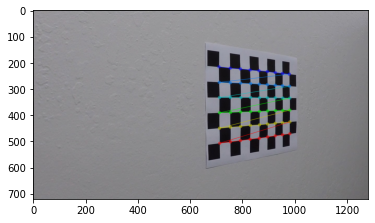

In [4]:
calibFileNames = glob.glob('camera_cal/calibration*.jpg')
cornersNotFoundCount = 0
lastImgWithCorners = None
for fname in calibFileNames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    patternWasFound, corners = cv2.findChessboardCorners(gray, patternSize, None)
    if patternWasFound == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, patternSize, corners, patternWasFound)
        lastImgWithCorners = img
        # save images locally
        # imgToSave = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        # cv2.imwrite('output_images/' + fname.split('/')[1], imgToSave)
    else:
        cornersNotFoundCount += 1

plt.imshow(lastImgWithCorners)
print("total images ", len(calibFileNames))
print("corners found ", len(objpoints))
print("corners not found ", cornersNotFoundCount)


 ## Camera Calibration: Calibrate, Undistort

In [5]:
# Calibrate camera -> get camera matrix and distortion coefficients
imgSizeXY = (lastImgWithCorners.shape[1], lastImgWithCorners.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSizeXY, None, None)


 ### Camera Calibration: Test image undistortion

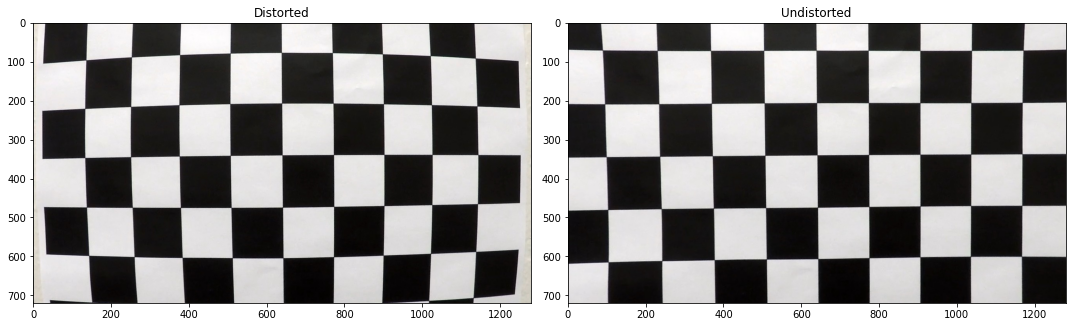

In [6]:
distortedImg = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(distortedImg, mtx, dist, None, mtx)
show_images([distortedImg, undist], ['Distorted', 'Undistorted'])


 ## Test Road Images - Original

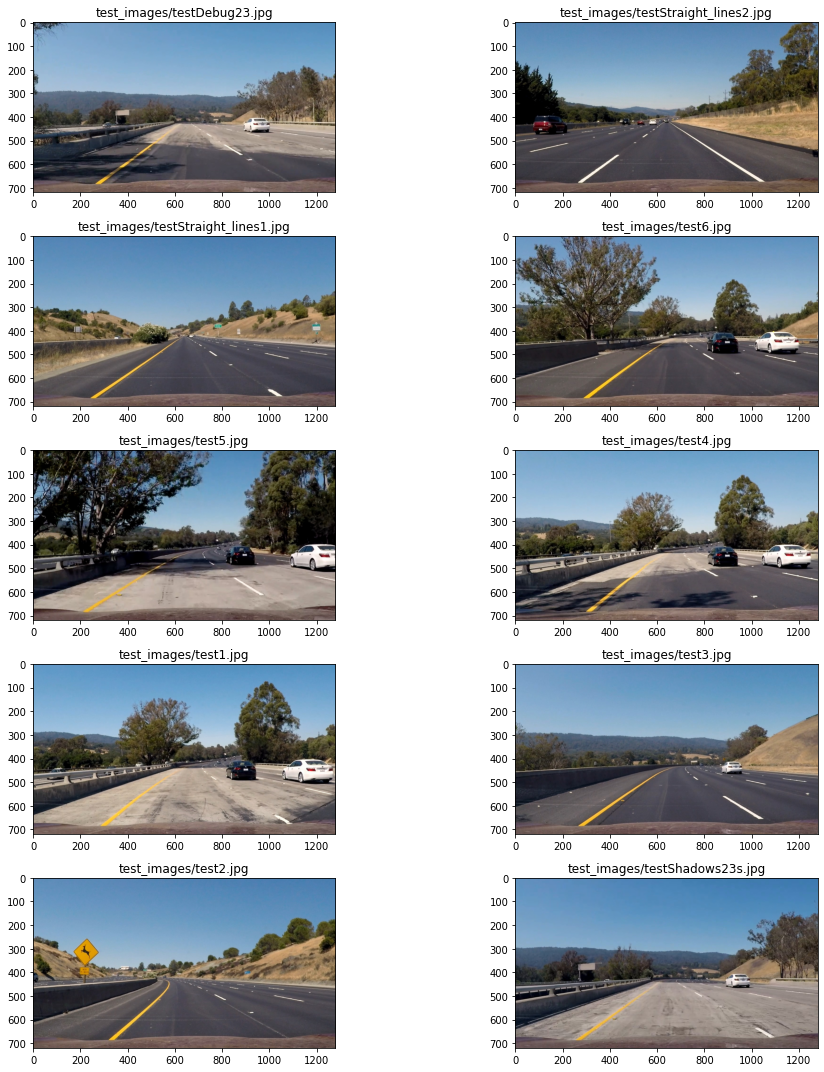

In [7]:
testRoadImgFnames = glob.glob('test_images/test*.jpg')
testRoadImages = list(map(lambda fname: mpimg.imread(fname), testRoadImgFnames))
show_images(testRoadImages, testRoadImgFnames)


 ## Test Road Images - Undistorted

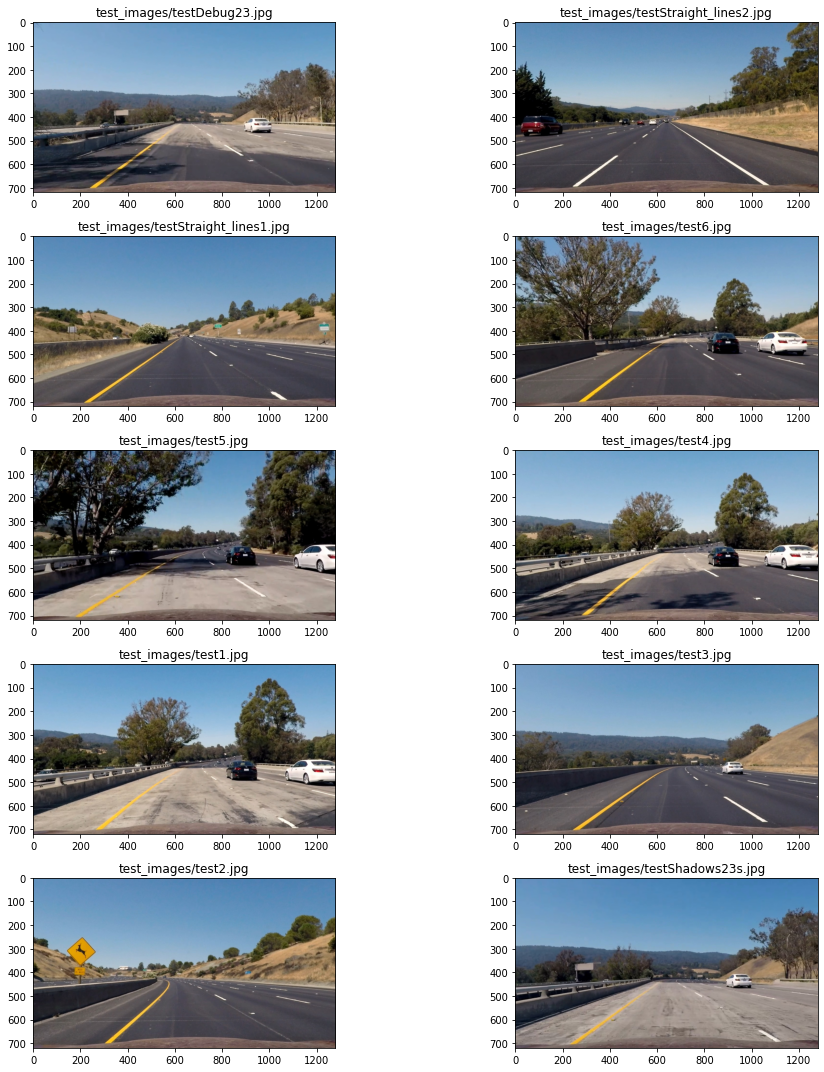

In [8]:
testRoadImagesUndist = list(map(lambda img: cv2.undistort(img, mtx, dist, None, mtx), testRoadImages))
show_images(testRoadImagesUndist, testRoadImgFnames, save=False, save_prefix='undistorted_')


 ## Perspective Transform: Define Trapezoid

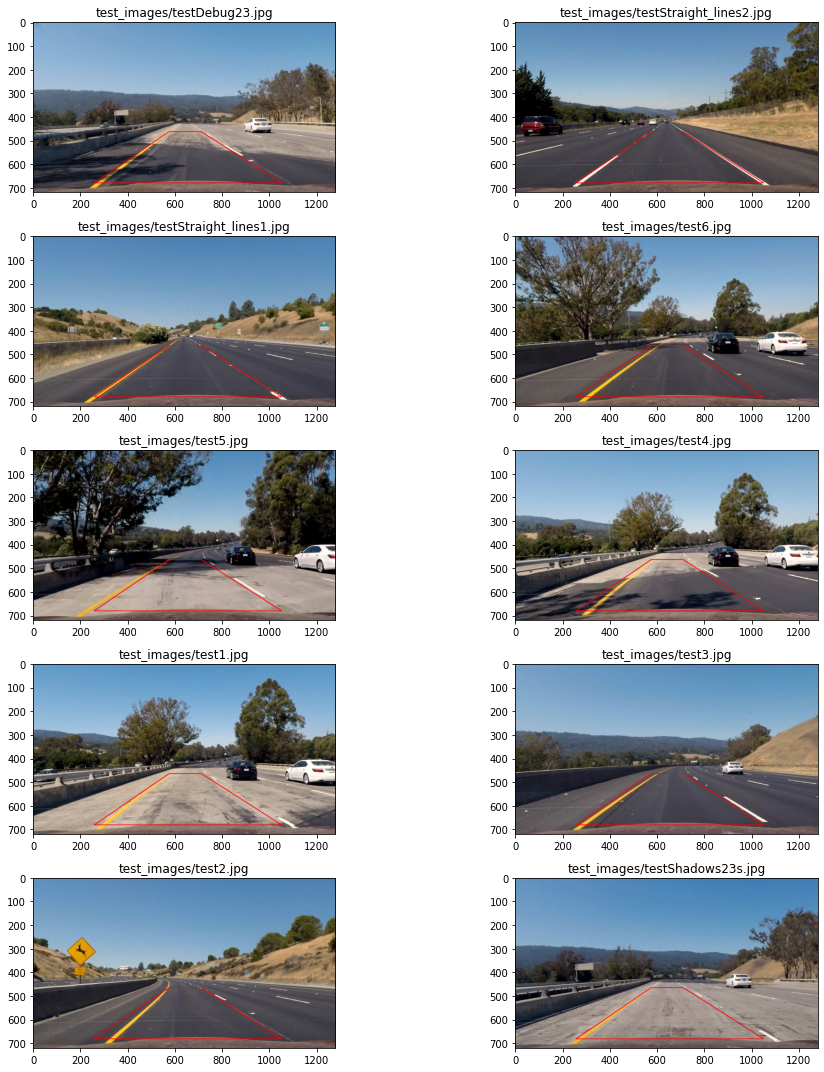

In [9]:
# Draw trapezoid, to see which params fit lanes best

def getTrapezoid():
    yBottom = 681
    yTop = 465
    xLeftBottom = 258
    xRightBottom = 1050
    xLeftUp = 575
    xRightUp = 710
    return np.array([[xRightBottom,yBottom],[xLeftBottom,yBottom],[xLeftUp,yTop],[xRightUp,yTop]], np.int32)

def drawTrapezoid(img):
    return cv2.polylines(np.copy(img), [getTrapezoid()], True, (255,0,0), thickness=2)

imgsWithTrapezoid = list(map(lambda img: drawTrapezoid(img), testRoadImagesUndist))
show_images(imgsWithTrapezoid, testRoadImgFnames, save=False, save_prefix='trapezoid')


 ## Perspective Transform: Warp Undistorted Images

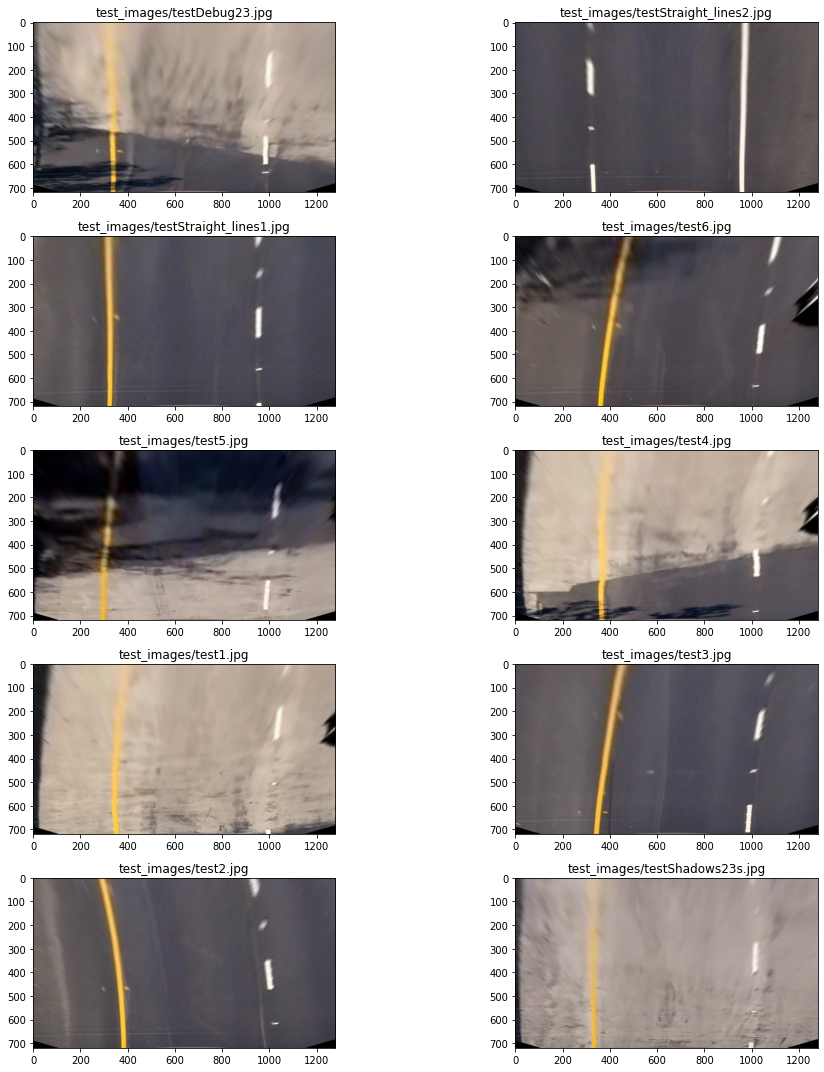

In [10]:
s = testRoadImages[0].shape
X = s[1]
Y = s[0]
srcPerspective = getTrapezoid().astype(np.float32)
warpXOffset = 320
dstPerspective = np.float32([(X-warpXOffset, Y), (warpXOffset, Y), (warpXOffset, 0), (X-warpXOffset, 0)])
M = cv2.getPerspectiveTransform(srcPerspective, dstPerspective)
MInv = cv2.getPerspectiveTransform(dstPerspective, srcPerspective)

warpedOriginal = list(map(lambda img: cv2.warpPerspective(img, M, (X, Y), flags=cv2.INTER_LINEAR), testRoadImagesUndist))
show_images(warpedOriginal, testRoadImgFnames, save=False, save_prefix='warpedOriginal_')


 ## Perspective Transform: Apply HLS S Channel Filtering, White Mask, Gradients Thresholds

In [11]:
def absoluteSobelThresh(img, orient='x', sobelKernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    xflag = yflag = 0
    if orient == 'x':
        xflag = 1
    elif orient == 'y':
        yflag = 1
    sobel = cv2.Sobel(gray, cv2.CV_64F, xflag, yflag, ksize=sobelKernel)

    sobelAbs = np.absolute(sobel)
    sobelScaled = (255 * (sobelAbs / np.max(sobelAbs))).astype(np.uint8)

    binaryInThresh = np.zeros_like(sobelScaled)
    binaryInThresh[(sobelScaled >= thresh[0]) & (sobelScaled < thresh[1])] = 1
    return binaryInThresh

def magnitudeThresh(img, sobelKernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)

    sobelMag = np.sqrt(sobelX**2 + sobelY**2)
    sobelScaled = (255 * (sobelMag/ np.max(sobelMag))).astype(np.uint8)

    binaryInThresh = np.zeros_like(sobelScaled)
    binaryInThresh[(sobelScaled >= thresh[0]) & (sobelScaled < thresh[1])] = 1
    return binaryInThresh

def directionThresh(img, sobelKernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)

    absGradDir = np.arctan2(np.absolute(sobelY), np.absolute(sobelX))

    binaryInThresh = np.zeros_like(absGradDir)
    binaryInThresh[(binaryInThresh >= thresh[0]) & (binaryInThresh < thresh[1])] = 1
    return binaryInThresh

def combinedGradientThresh(img):
    ksize = 15
    gradX = absoluteSobelThresh(img, orient='x', sobelKernel=ksize, thresh=(20,100))
    gradY = absoluteSobelThresh(img, orient='y', sobelKernel=ksize, thresh=(20,100))
    gradMag = magnitudeThresh(img, sobelKernel=ksize, thresh=(30, 100))
    gradDir = directionThresh(img, sobelKernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(gradX)
    combined[((gradX == 1) & (gradY == 1)) | (gradMag == 1) & (gradDir == 1)] = 1
    return combined

def hlsSChannelThresh(img, sThresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sChan = hls[:,:,2]

    sBinary = np.zeros_like(sChan)
    sBinary[(sChan >= sThresh[0]) & (sChan < sThresh[1])] = 1
    return sBinary

def combinedFiltering(img, debug=False):
    sChanThresh = hlsSChannelThresh(img)
    combinedGradient = combinedGradientThresh(img)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    whiteMask = cv2.inRange(gray, 220, 255) / 255

    # s channel - red; white mask - green; gradient - blue, for debugging
    if debug == True:
        combinedImg = (np.dstack((sChanThresh, whiteMask, combinedGradient)) * 255).astype(np.uint8)
        return np.vstack((img, combinedImg))
    binary = np.zeros_like(sChanThresh).astype(np.uint8)
    binary[(sChanThresh == 1) | (whiteMask == 1)] = 1
    return binary



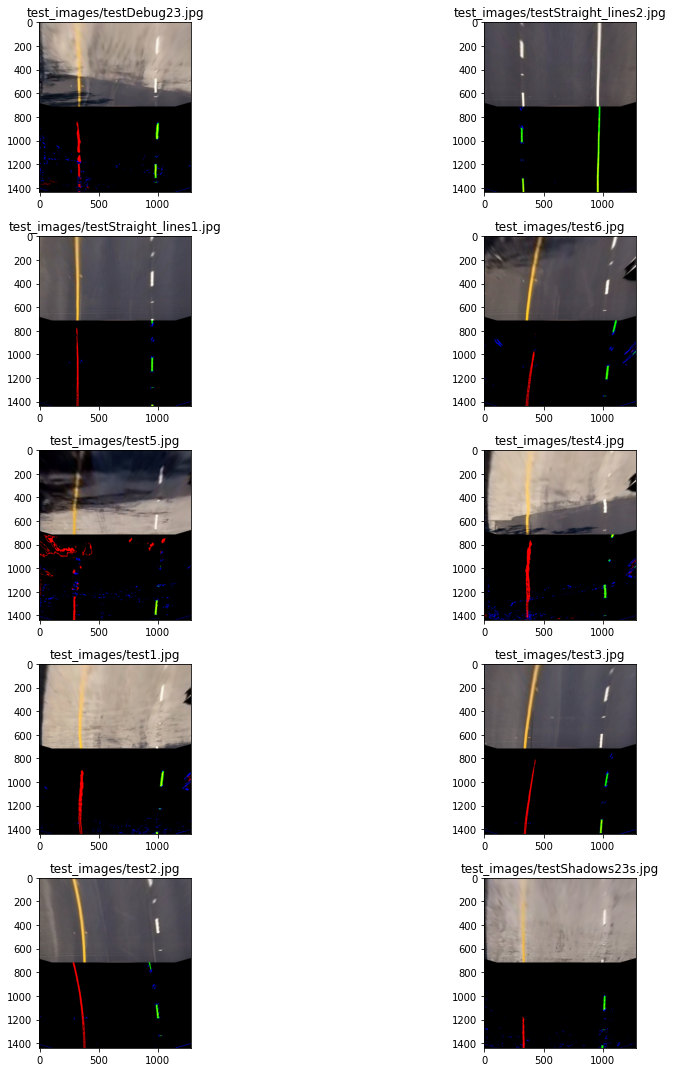

In [12]:
threshImgsDebug = list(map(lambda img: combinedFiltering(img, debug=True), warpedOriginal))
show_images(threshImgsDebug, testRoadImgFnames, save=False, save_prefix='combinedThreshDebug_')



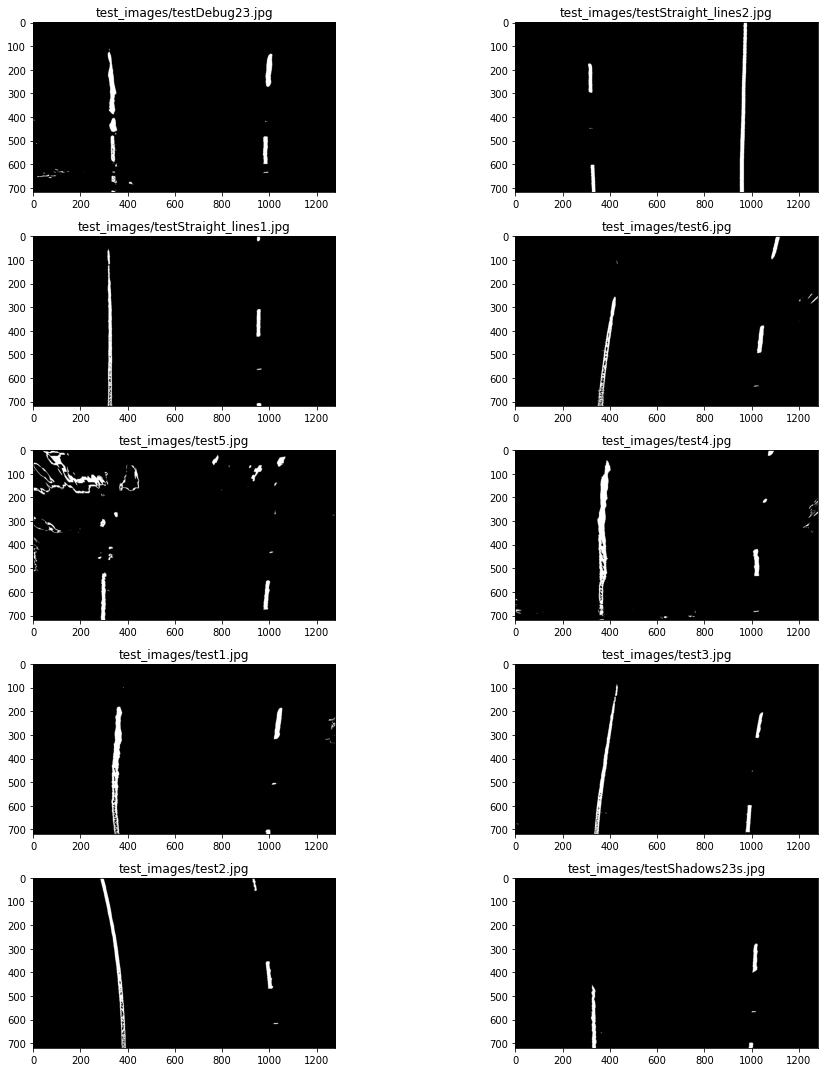

In [13]:
threshImgs = list(map(lambda img: combinedFiltering(img), warpedOriginal))
show_images(threshImgs, testRoadImgFnames)


 ## Detect Left & Right Lines, Fit Polynomial

In [14]:
def hist(img):
    bottomHalf = img[img.shape[0]//2:, :]
    histogram = np.sum(bottomHalf, axis=0)
    return histogram

def findLanePixels(warpedImg, debug=False):
    histogram = hist(warpedImg)
    midpoint = histogram.shape[0]//2
    leftBase = np.argmax(histogram[:midpoint])
    rightBase = midpoint + np.argmax(histogram[midpoint:])

    ySize = warpedImg.shape[0]
    xSize = warpedImg.shape[1]
    margin = 90
    minpix = 50
    nwindows = 9
    height = ySize // nwindows

    nonzero = warpedImg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    allLeftLaneIndices = []
    allRightLaneIndices = []

    currentBaseLeft = leftBase
    currentBaseRight = rightBase
    outImg = None
    if debug:
        outImg = np.dstack((warpedImg,)*3) * 255
    for window in range(nwindows):
        leftYBottom = rightYBottom = ySize - window * height
        leftYTop = rightYTop = ySize - (window+1) * height
        leftXLeft = currentBaseLeft - margin
        leftXRight = currentBaseLeft + margin
        rightXLeft = currentBaseRight - margin
        rightXRight = currentBaseRight + margin

        if debug:
            cv2.rectangle(outImg,(leftXLeft,leftYBottom),(leftXRight,leftYTop),(0,255,0), 2)
            cv2.rectangle(outImg,(rightXLeft,rightYBottom),(rightXRight,rightYTop),(0,0,255), 2)

        leftIndices = ((nonzerox >= leftXLeft) & (nonzerox < leftXRight) & (nonzeroy >= leftYTop) & (nonzeroy < leftYBottom)).nonzero()[0]
        rightIndices = ((nonzerox >= rightXLeft) & (nonzerox < rightXRight) & (nonzeroy >= rightYTop) & (nonzeroy < rightYBottom)).nonzero()[0]

        if len(leftIndices) > minpix:
            currentBaseLeft = np.int(np.mean(nonzerox[leftIndices]))
        if len(rightIndices) > minpix:
            currentBaseRight = np.int(np.mean(nonzerox[rightIndices]))

        allLeftLaneIndices.append(leftIndices)
        allRightLaneIndices.append(rightIndices)

    allLeftLaneIndices = np.concatenate(allLeftLaneIndices)
    allRightLaneIndices = np.concatenate(allRightLaneIndices)

    leftX = nonzerox[allLeftLaneIndices]
    leftY = nonzeroy[allLeftLaneIndices]
    rightX = nonzerox[allRightLaneIndices]
    rightY = nonzeroy[allRightLaneIndices]
    return leftX, leftY, rightX, rightY, outImg

def fitPoly(imgShape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial
    leftFit = np.polyfit(lefty, leftx, 2)
    rightFit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    plotY = np.linspace(0, imgShape[0]-1, imgShape[0])
    leftFitX = leftFit[0]*plotY**2 + leftFit[1]*plotY + leftFit[2]
    rightFitX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]
    return leftFitX, rightFitX, plotY, leftFit, rightFit

def fitPolynomialFromScratch(warpedImg, debug=False):
    leftX, leftY, rightX, rightY, outImg = findLanePixels(warpedImg, debug)
    leftFitX, rightFitX, plotY, leftFit, rightFit = fitPoly(warpedImg.shape, leftX, leftY, rightX, rightY)

    if debug:
        outImg[leftY, leftX] = [0, 255, 0]
        outImg[rightY, rightX] = [0, 0, 255]

        polyline1 = np.array(list(zip(leftFitX, plotY)))
        polyline2 = np.array(list(zip(rightFitX, plotY)))
        cv2.polylines(outImg, np.int32([polyline1, polyline2]), False, (255,255,0), thickness=4)
    return leftFitX, rightFitX, plotY, leftFit, rightFit, outImg

def searchAroundPoly(warpedImg, leftFit, rightFit):
    margin = 100
    nonzero = warpedImg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftLaneIndices = ((nonzerox >= leftFit[0]*nonzeroy**2 + leftFit[1]*nonzeroy + leftFit[2] - margin) & 
                      (nonzerox <= leftFit[0]*nonzeroy**2 + leftFit[1]*nonzeroy + leftFit[2] + margin)).nonzero()[0]
    rightLaneIndices = ((nonzerox >= rightFit[0]*nonzeroy**2 + rightFit[1]*nonzeroy + rightFit[2] - margin) & 
                       (nonzerox <= rightFit[0]*nonzeroy**2 + rightFit[1]*nonzeroy + rightFit[2] + margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[leftLaneIndices]
    lefty = nonzeroy[leftLaneIndices] 
    rightx = nonzerox[rightLaneIndices]
    righty = nonzeroy[rightLaneIndices]

    # Fit new polynomials
    return fitPoly(warpedImg.shape, leftx, lefty, rightx, righty)


 ### Find start of a line using histogram peak, then apply sliding window

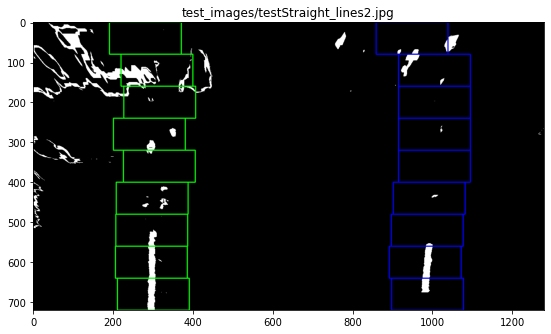

In [15]:
leftX, leftY, rightX, rightY, imgWithLanePixels = findLanePixels(threshImgs[4], debug=True)
show_images([imgWithLanePixels], [testRoadImgFnames[1]], save=False, save_prefix='laneRectanglesAdjusted_')


 ### Fit polynomial to detected line pixels.
 We treat y axis as free variable for our polynomial, since fit is vertical

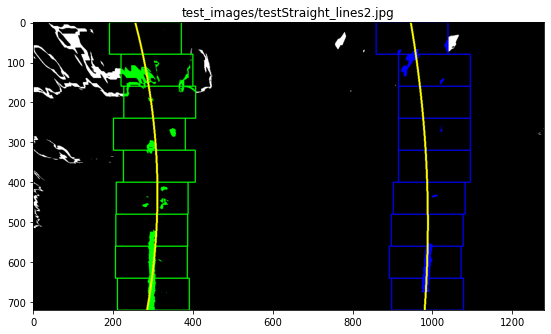

left fit [-3.04341279e-04  2.60122475e-01  2.56136384e+02]
right fit [-1.70058649e-04  1.70584230e-01  9.46289014e+02]


In [16]:
leftFitX, rightFitX, plotY, leftFit, rightFit, imgWithPoly = fitPolynomialFromScratch(threshImgs[4], debug=True)
show_images([imgWithPoly], [testRoadImgFnames[1]], save=False, save_prefix='fitPoly_')
print("left fit", leftFit)
print("right fit", rightFit)



 ## Draw Lane

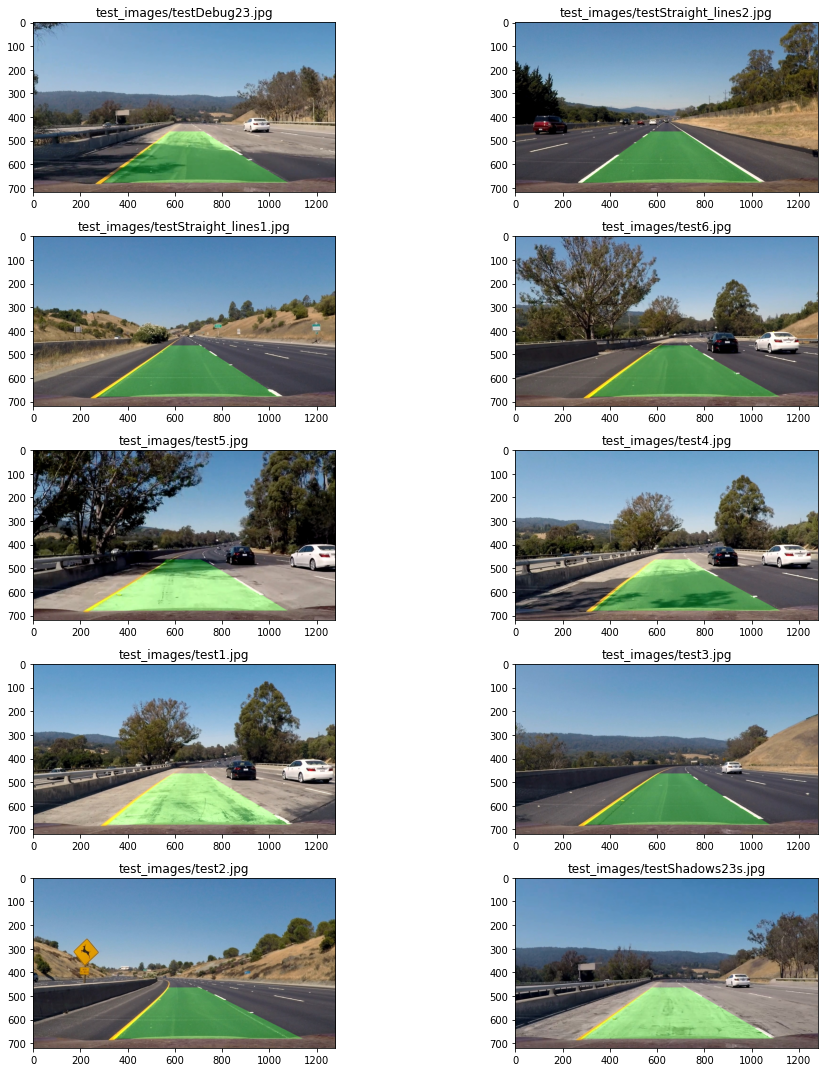

In [17]:
def drawLane(undistImage, binaryWarped, Minv, leftFitX, rightFitX, plotY):
    warp_zero = np.zeros_like(binaryWarped).astype(np.uint8)
    colorWarp = np.dstack((warp_zero, warp_zero, warp_zero))

    ptsLeft = np.array([np.transpose(np.vstack([leftFitX, plotY]))])
    ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitX, plotY])))])
    pts = np.hstack((ptsLeft, ptsRight))
    cv2.fillPoly(colorWarp, np.int_([pts]), (0, 255, 0))

    ySize = undistImage.shape[0]
    xSize = undistImage.shape[1]
    newWarp = cv2.warpPerspective(colorWarp, Minv, (xSize, ySize))
    result = cv2.addWeighted(undistImage, 1, newWarp, 0.3, 0)
    return result

fittedLanes = list(map(lambda warped: fitPolynomialFromScratch(warped), threshImgs))
imgsWithLanes = []
for i in range(len(testRoadImages)):
    imgsWithLanes.append(drawLane(testRoadImages[i], threshImgs[i], MInv, fittedLanes[i][0], fittedLanes[i][1], fittedLanes[i][2]))
show_images(imgsWithLanes, testRoadImgFnames, save=False, save_prefix='laneOnRoad_')


 ## Line Outliers Detection: Get Intuition on Coefficients

In [18]:
leftFits = [];
rightFits = [];
for i in range(len(fittedLanes)):
    leftFits.append(fittedLanes[i][3])
    rightFits.append(fittedLanes[i][4])
    print("left fit", fittedLanes[i][3])
    print("right fit", fittedLanes[i][4])
    print("diff", np.absolute(fittedLanes[i][3] - fittedLanes[i][4]))
    print("---------")
print("----------")
print("----------")
print("all left fits", np.array(leftFits))
print("all right fits", np.array(leftFits))


left fit [2.60838762e-05 1.72656163e-02 3.24563701e+02]
right fit [ 1.01899838e-04 -1.19866383e-01  1.01661574e+03]
diff [7.58159622e-05 1.37131999e-01 6.92052040e+02]
---------
left fit [ 3.65135183e-05 -5.61684009e-03  3.17177808e+02]
right fit [ 8.23241025e-06 -2.94964508e-02  9.73590283e+02]
diff [2.82811081e-05 2.38796107e-02 6.56412475e+02]
---------
left fit [-4.14438743e-05  4.12511056e-02  3.15398696e+02]
right fit [ 6.83008373e-06 -1.92353920e-03  9.52239886e+02]
diff [4.82739581e-05 4.31746448e-02 6.36841191e+02]
---------
left fit [ 7.57240398e-05 -2.09633151e-01  4.70384859e+02]
right fit [ 1.30017685e-04 -2.25094227e-01  1.11070181e+03]
diff [5.42936448e-05 1.54610755e-02 6.40316951e+02]
---------
left fit [-3.04341279e-04  2.60122475e-01  2.56136384e+02]
right fit [-1.70058649e-04  1.70584230e-01  9.46289014e+02]
diff [1.34282630e-04 8.95382447e-02 6.90152630e+02]
---------
left fit [ 9.62685382e-05 -9.76625820e-02  3.90847933e+02]
right fit [ 1.73913189e-04 -2.16909455e

 ## Find Lane on Video: Complete Pipeline

In [19]:

ym_per_pix = 30/720
xm_per_pix = 3.7/700
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        self.ploty = None
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        self.xLanePosPix = None

    def addNewLineFit(self, imgShape, fitX, plotY, fit):
        self.ploty = plotY
        if self.current_fit is not None:
            self.diffs = np.absolute(self.current_fit - fit)

        # check if detected line is OK or not
        if (self.diffs[0] <= 0.0003 and \
                self.diffs[1] <= 0.1 and \
                self.diffs[2] <= 150) or not self.detected:
            self.current_fit = fit
            self.recent_xfitted.append(fitX)
            self.recent_xfitted = self.recent_xfitted[-20:]
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            self.best_fit = np.polyfit(plotY, self.bestx, 2)
            self.measureCurvatureRadiusAndLineBasePos(imgShape)
            self.detected = True
        else:
            self.detected = False

    def measureCurvatureRadiusAndLineBasePos(self, imgShape):
        fit_cr = np.polyfit(self.ploty*ym_per_pix, self.bestx*xm_per_pix, 2)
        yMax = np.max(self.ploty)
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*yMax*ym_per_pix+fit_cr[1])**2)**(3/2)) / abs(2*fit_cr[0])

        self.xLanePosPix = self.best_fit[0]*yMax**2 + self.best_fit[1]*yMax + self.best_fit[2]

class LaneFinder():
    def __init__(self):
        self.imgShape = None
        self.leftLine = Line()
        self.rightLine = Line()
        self.vehicleCenterOffset = None

    def calculateVehicleCenterOffset(self):
        laneCenter = (self.leftLine.xLanePosPix + self.rightLine.xLanePosPix) / 2
        midX = self.imgShape[1] / 2
        self.vehicleCenterOffset = (laneCenter - midX) * xm_per_pix

    def formatVehiclePosition(self):
        leftOrRight = "right"
        if self.vehicleCenterOffset > 0:
            leftOrRight = "left"
        text = "Vehicle is " + str(round(abs(self.vehicleCenterOffset), 2)) + "m " + leftOrRight + " of center"
        return text

    def processNextFrame(self, img):
        if self.imgShape is None:
            self.imgShape = img.shape

        undist = cv2.undistort(img, mtx, dist, None, mtx)
        warped = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        binaryFiltered = combinedFiltering(warped)
    
        distLinesLow = 2.5
        distLinesHigh = 3.9
        distBetweenLinesMeters = 3
        if self.leftLine.xLanePosPix is not None and self.rightLine.xLanePosPix is not None:
            distBetweenLinesMeters = abs(self.leftLine.xLanePosPix - self.rightLine.xLanePosPix)*xm_per_pix
        leftLinePriorSearch = False;
        rightLinePriorSearch = False;

        # decide either to search around previous polynomial or start line search from scratch
        if self.leftLine.detected and distBetweenLinesMeters >= distLinesLow and distBetweenLinesMeters <= distLinesHigh:
            leftLinePriorSearch = True;
            leftFitX, _, plotY, leftFit, _ = searchAroundPoly(binaryFiltered, self.leftLine.current_fit, self.rightLine.current_fit)
        else:
            leftFitX, _, plotY, leftFit, _, _ = fitPolynomialFromScratch(binaryFiltered)

        # decide either to search around previous polynomial or start line search from scratch
        if self.rightLine.detected and distBetweenLinesMeters >= distLinesLow and distBetweenLinesMeters <= distLinesHigh:
            rightLinePriorSearch = True;
            _, rightFitX, _, _, rightFit = searchAroundPoly(binaryFiltered, self.leftLine.current_fit, self.rightLine.current_fit)
        else:
            _, rightFitX, _, _, rightFit, _ = fitPolynomialFromScratch(binaryFiltered)

        # add new fits to lines objects
        self.leftLine.addNewLineFit(img.shape, leftFitX, plotY, leftFit)
        self.rightLine.addNewLineFit(img.shape, rightFitX, plotY, rightFit)

        self.calculateVehicleCenterOffset()

        # draw lane
        imgWithLane = drawLane(undist, binaryFiltered, MInv, self.leftLine.bestx, self.rightLine.bestx, plotY)

        color=(0, 255, 0)
        thick = 10

        radiusOfCurvatureMean = np.mean([self.leftLine.radius_of_curvature, self.rightLine.radius_of_curvature])
        curvatureText = 'Radius of Curvature = ' + str(round(radiusOfCurvatureMean, 2)) + '(m)'
        cv2.putText(imgWithLane, curvatureText, (20, 100), cv2.LINE_AA, 2, color, thick)

        cv2.putText(imgWithLane, self.formatVehiclePosition(), (20, 200), cv2.LINE_AA, 2, color, thick)

        # used for debugging
        debug=False
        if debug:
            distBetweenLinesText = "Distance between lines (m)" + str(round(distBetweenLinesMeters, 2))
            cv2.putText(imgWithLane, distBetweenLinesText, (20, 260), cv2.LINE_AA, 2, color, thick)
            cv2.putText(imgWithLane, "L Prior " + str(leftLinePriorSearch), (20, 320), cv2.LINE_AA, 2, color, thick)
            cv2.putText(imgWithLane, "R Prior " + str(rightLinePriorSearch), (500, 320), cv2.LINE_AA, 2, color, thick)

        return imgWithLane
        


 ## Test Complete Pipeline on Test Images

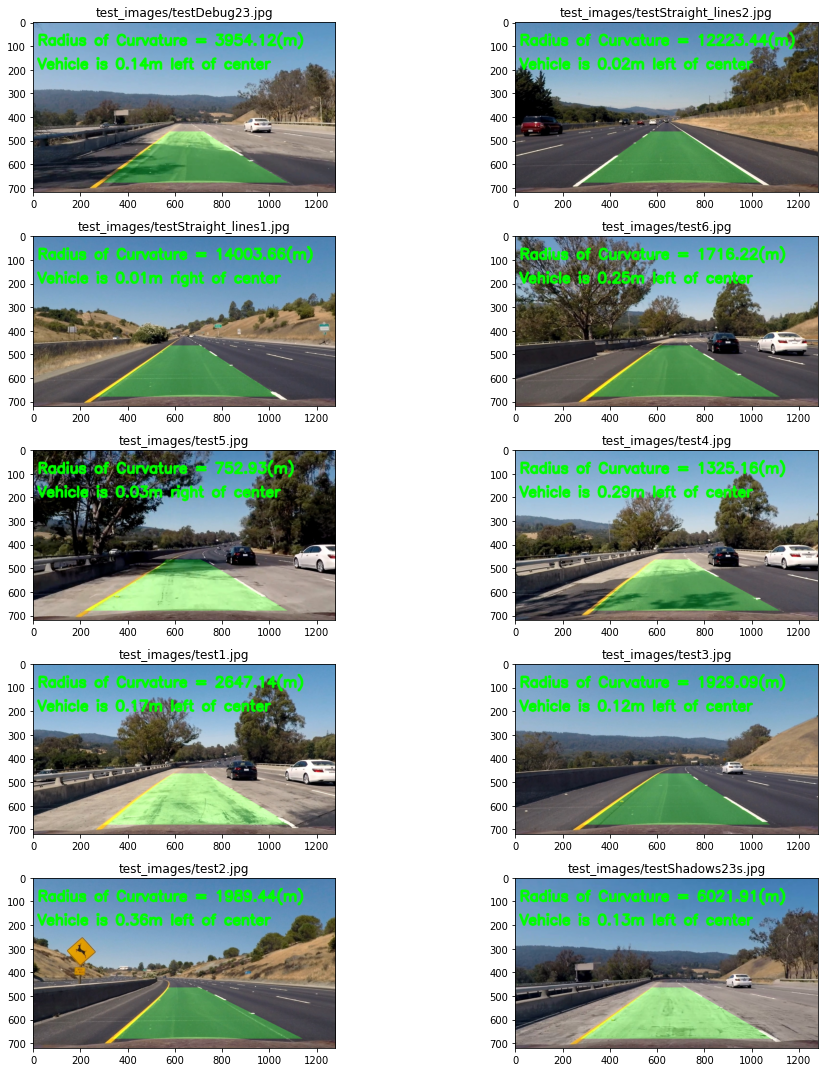

In [20]:
processedImgs = []
for i in range(len(testRoadImages)):
    laneFinder = LaneFinder()
    processedImgs.append(laneFinder.processNextFrame(testRoadImages[i]))
show_images(processedImgs, testRoadImgFnames, save=False, save_prefix='processedFinal_')


 ## Find Lanes on Video

In [21]:

outputFname1 = 'project_video_output.mp4'
# clip1 = VideoFileClip('project_video.mp4')
# laneFinder = LaneFinder()
# processedClip1 = clip1.fl_image(laneFinder.processNextFrame)
# processedClip1.write_videofile(outputFname1, audio=False)


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputFname1))
